In [1]:
import logging
from batch_size_studies.experimental_mnist_training import load_mnist_gamma_eta_sweep_results
from batch_size_studies.experiments import MNIST1MSampledExperiment
from batch_size_studies.definitions import Parameterization
from batch_size_studies.paths import EXPERIMENTS_DIR
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)

from batch_size_studies.definitions import RunKey, LossType

# Gamma-eta sweep

This notebook serves as sanity checks for our training runs. We recover here the plots of Atanasov-Meterez. The relevant script to run to populate data for this experiment is `scripts/run_experimental_sweep.py`

In [2]:
# Use the default values from the script as an example.

base_exp_config = MNIST1MSampledExperiment(
    N=128,
    L=3,
    parameterization=Parameterization.MUP,
    num_epochs=1,
    max_train_samples=100_000,
    loss_type=LossType.MSE #LossType.MSE
)


GAMMA_RANGE = 5
GAMMA_RES = 2

In [3]:
print("--- Loading sweep results ---")
loaded_results, loaded_failures = load_mnist_gamma_eta_sweep_results(
    base_experiment=base_exp_config,
    gamma_range=GAMMA_RANGE,
    gamma_res=GAMMA_RES,
    directory=EXPERIMENTS_DIR,
    save_subfolder="sanity_checks",
);

INFO:root:Loading sweep results from: /Users/stanislav/Desktop/coding/Pehlevan lab recover/batch_size_studies/experiments/sanity_checks


--- Loading sweep results ---


INFO:root:Results file found, loading from: results_D=784_L=3_N=128_gamma=1e-05_loss_type=MSE_max_train_samples=100000_optimizer=SGD_parameterization=muP.pkl
INFO:root:Results file found, loading from: results_D=784_L=3_N=128_gamma=3p1622776601683795e-05_loss_type=MSE_max_train_samples=100000_optimizer=SGD_parameterization=muP.pkl
INFO:root:Results file found, loading from: results_D=784_L=3_N=128_gamma=0p0001_loss_type=MSE_max_train_samples=100000_optimizer=SGD_parameterization=muP.pkl
INFO:root:Results file found, loading from: results_D=784_L=3_N=128_gamma=0p00031622776601683794_loss_type=MSE_max_train_samples=100000_optimizer=SGD_parameterization=muP.pkl
INFO:root:Results file found, loading from: results_D=784_L=3_N=128_gamma=0p001_loss_type=MSE_max_train_samples=100000_optimizer=SGD_parameterization=muP.pkl
INFO:root:Results file found, loading from: results_D=784_L=3_N=128_gamma=0p0031622776601683794_loss_type=MSE_max_train_samples=100000_optimizer=SGD_parameterization=muP.pkl
I

In [4]:
print("\n--- Loading complete ---")
if loaded_results:
    print(f"Successfully loaded results for {len(loaded_results)} gamma values.")
else:
    print("No results were loaded. Please check that your configuration and paths are correct.")




--- Loading complete ---
Successfully loaded results for 21 gamma values.


In [5]:
BATCH_SIZE = 256
loss_dict = defaultdict(list)

In [6]:
gammas = set(loaded_results.keys())
etas = {
    rk.eta
    for gamma_results in loaded_results.values()
    for rk in gamma_results.keys()
}

In [7]:
gammas = np.array(sorted(list(gammas)))
etas = np.array(sorted(list(etas)))

In [8]:
print(np.log10(gammas))
print(np.log10(etas))

[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5. ]
[-9.5  -9.25 -9.   -8.75 -8.5  -8.25 -8.   -7.75 -7.5  -7.25 -7.   -6.75
 -6.5  -6.25 -6.   -5.75 -5.5  -5.25 -5.   -4.75 -4.5  -4.25 -4.   -3.75
 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.   -1.75 -1.5  -1.25 -1.   -0.75
 -0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25
  2.5   2.75  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25
  5.5   5.75  6.    6.25  6.5   6.75]


In [9]:
for gamma0 in gammas:
    for eta0 in etas:
        rk = RunKey(batch_size=BATCH_SIZE, eta=eta0)
        if rk in loaded_results[gamma0]:
            loss_dict[gamma0, eta0] = loaded_results[gamma0][RunKey(batch_size=BATCH_SIZE, eta=eta0)]['loss_history']

In [10]:
L = base_exp_config.L
N = base_exp_config.N
D = base_exp_config.D

Here we generate plots like in "Optimization Landscape Across Feature Learning Strength" by Atanasov et al. The derivation of the optimal learning rate scale $\eta_*$ being $\gamma^2$ and $\gamma^{2/L}$ for lazy and rich networks, respectively, are found therein.

Text(0.5, 1.0, 'Online Loss at $t = 360$,  MLP \n$D=$784, $N=$128, $L=$3')

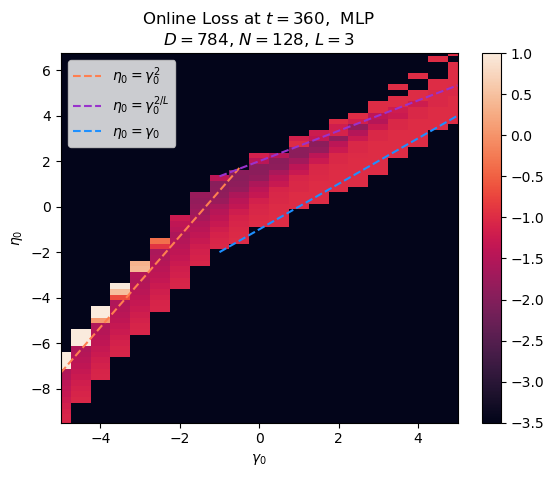

In [11]:
t = 360

X, Y = np.meshgrid(gammas, etas)
Z = np.zeros_like(X)
for i, gamma in enumerate(gammas):
    for j, eta in enumerate(etas):
        if len(loss_dict[(gamma, eta)]) <= t: continue

        Z[j,i] = np.log10(loss_dict[(gamma, eta)][t])

plt.figure()
# replace all zero entries with nan:
Z[Z==0] = -100

plt.pcolormesh(np.log10(X), np.log10(Y), Z, cmap='rocket')


plt.plot(np.log10(gammas)[:10], np.log10(5e2*gammas**2)[:10], c='coral', ls='--', label='$\\eta_0 = \\gamma_0^2$')
plt.plot(np.log10(gammas)[8:], np.log10(1e2*gammas**(2/L))[8:], c='darkorchid', ls='--', label='$\\eta_0 = \\gamma_0^{{2/L}}$')
plt.plot(np.log10(gammas)[8:], np.log10(1e-1*gammas)[8:], c='dodgerblue', ls='--', label='$\\eta_0 = \\gamma_0$')


plt.xlim(min(np.log10(gammas)), max(np.log10(gammas)))
plt.ylim(min(np.log10(etas)), max(np.log10(etas)))

plt.clim(-3.5,1)
plt.legend()
plt.colorbar()
plt.xlabel('$\\gamma_0$')
plt.ylabel('$\\eta_0$')
plt.title(f"Online Loss at $t = {t}$,  MLP \n$D=${D}, $N=${N}, $L=${L}")

# Catapulting for lazy networks

This part is mostly for sanity checks

In [12]:
candidate_eta = defaultdict(float) #largest converging eta for each gamma
for gamma0 in gammas[:10]:
    for eta0 in etas[::-1]:
        if len(loss_dict[gamma0, eta0]) > 0:
            candidate_eta[gamma0] = eta0
            break

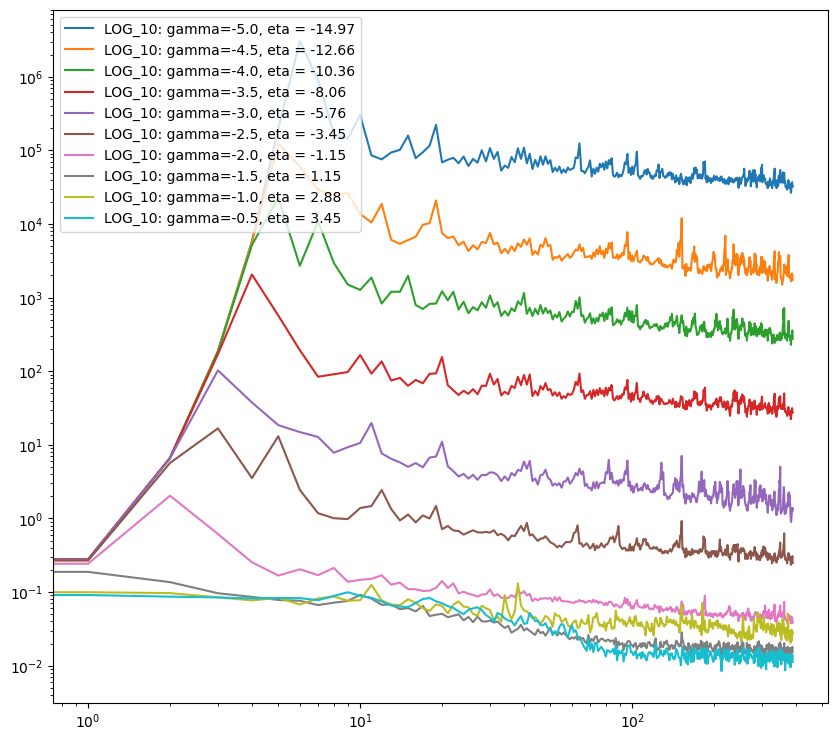

In [13]:
plt.figure(figsize=(10,9))
for gamma0 in gammas[:10]:
    plt.loglog(loss_dict[gamma0, candidate_eta[gamma0]], label=f'LOG_10: gamma={np.log10(gamma0)}, eta = {np.log(candidate_eta[gamma0]):.2f}')
plt.legend()
plt.show()